In [1]:
import os

# Set the current working directory to the immediate upper folder
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))

In [2]:
from data.B_iam_paragraphs import BIAMParagraphs
import numpy as np
import wandb

c:\Users\Salekin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
data = BIAMParagraphs()
data.setup()
print(data)

B_IAM Paragraphs Dataset
Num classes: 1350
Input dims : (1, 1000, 1000)
Output dims: (700, 1)
Train/val/test sizes: 25, 7, 7



In [4]:
x, y = next(iter(data.test_dataloader()))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([7, 1, 1000, 1000]) torch.float32
torch.Size([7, 700]) torch.int64


In [5]:

def show(y):
    y = y.detach().cpu().numpy().squeeze().tolist() # bring back from accelerator if it's being used
    return "".join((data.mapping[token_id]) for token_id in y).replace("<P>", "")

<S>আমার সোনার বাংলা
আমি তোমায় ভালবাসি
চিরদিন তোমার আকাশ তোমার বাতাস আমর প্রাণে
ওমা আমার প্রাণে বাজাই বাশি
ওমা ফাগুনে তোর আমের বনে গ্রানে
পাগল করে -এ -এ -এ
ওমা অগ্রানে তোর ভরা ক্ষেতে কি দেখেছি
আমি কি দেখেছি মধুর হাসি
সোনার বাংলা
আমি তোমায় ভালবাসি।<E>


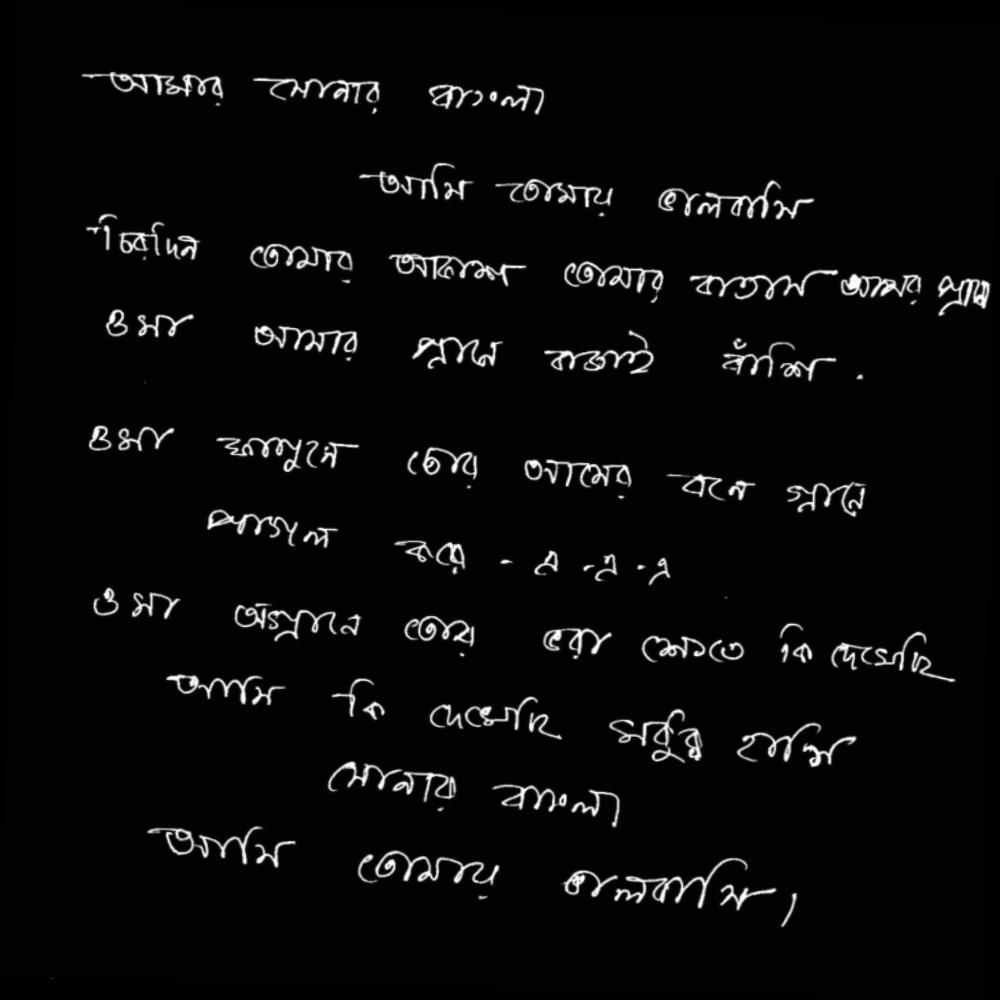

In [6]:
rand_i = np.random.randint(len(data.data_train))
img, label = data.data_train[rand_i]
print(show(label))
wandb.Image(img).image


In [7]:
import torch

start_index = data.inverse_mapping["<S>"]
end_index = data.inverse_mapping["<E>"]
padding_index = data.inverse_mapping["<P>"]

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from models.resnet_transformer import ResnetTransformer
model = ResnetTransformer(data_config=data.config()).to(device)

In [10]:
from lit_models.metrics import CharacterErrorRate
import torch.nn as nn
import warnings

num_epochs = 1

criterion = nn.CrossEntropyLoss(ignore_index=padding_index)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ignore_tokens = [start_index, end_index, padding_index]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    val_cer = CharacterErrorRate(ignore_tokens)
    test_cer = CharacterErrorRate(ignore_tokens)


In [11]:
def teacher_forward(x, y):
        x = model.encode(x)
        output = model.decode(x, y)  # (Sy, B, C)
        return output.permute(1, 2, 0)  # (B, C, Sy)

In [12]:
train_dataloader = data.train_dataloader()
val_dataloader = data.val_dataloader()
test_dataloader = data.test_dataloader()

In [13]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = teacher_forward(x, y[:, :-1])
        loss = criterion(logits, y[:, 1:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x,y in val_dataloader:  # Use test_dataloader for testing
            x = x.to(device)
            y = y.to(device)
            logits = teacher_forward(x, y[:, :-1])
            val_loss = criterion(logits, y[:, 1:])
            preds = model(x)
            val_cer(preds, y)  
            print(f"epoch: {epoch}, val loss: {val_loss}, val_cer:{val_cer.compute()}")

c:\Users\Salekin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 4.00 GiB total capacity; 9.29 GiB already allocated; 0 bytes free; 9.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF